In [419]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [420]:
import numpy as np
import pandas as pd

In [421]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [422]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [423]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [424]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [425]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [426]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [427]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

# Exploratory Climate Analysis

Last recorded date: 2017-08-23


Text(0.5, 1.0, 'Total inches of rain in the past year')

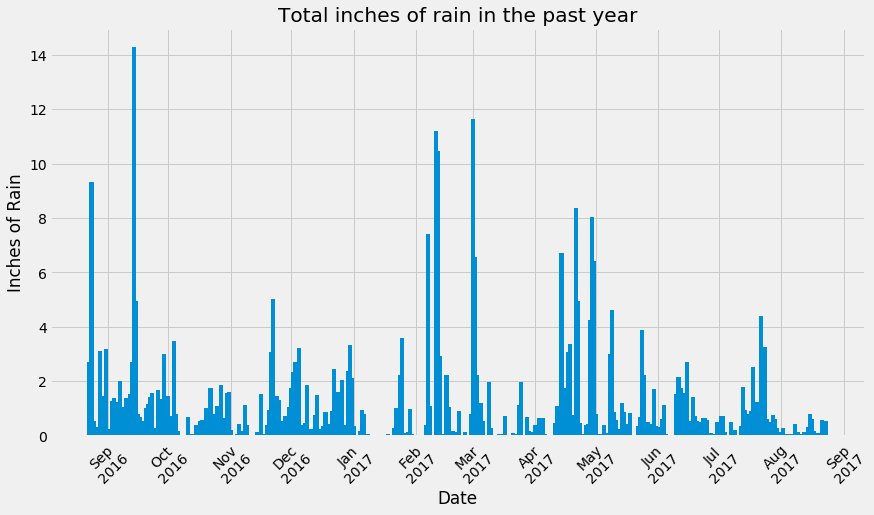

In [428]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

results2 = session.query(Measurement.date)
date_data_2 = [result[0] for result in results2[:]]
date_data_2.sort(reverse=True)
print("Last recorded date: " + date_data_2[0])
#the last date recorded is 2017-08-23 so we will look for 2016-08-23 and newer

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.station, Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-23")
station_data = [result[0] for result in results[:]]
date_data = [result[1] for result in results[:]]
prcp_data = [result[2] for result in results[:]]

#formatting date_data from strings to dates
date_data_formatted = [dt.datetime.strptime(x, "%Y-%m-%d").date() for x in date_data]
#date_data_formatted = [mdates.date2num(y) for y in date_data_formatted]

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

prcp_data_df = pd.DataFrame(list(zip(station_data, date_data_formatted, prcp_data)),columns=["Station","Date","Precip"])
prcp_data_df = prcp_data_df.groupby(["Date"]).sum()
prcp_data_df = prcp_data_df.reset_index()

plt.figure(figsize=(13,7))
plt.bar(prcp_data_df["Date"],prcp_data_df["Precip"],width=2)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
plt.xticks(rotation=45)
plt.ylabel("Inches of Rain")
plt.xlabel("Date")
plt.title("Total inches of rain in the past year")

In [429]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_data_df["Precip"].describe()

count    366.000000
mean       0.978907
std        1.776349
min        0.000000
25%        0.052500
50%        0.405000
75%        1.087500
max       14.280000
Name: Precip, dtype: float64

In [430]:
# Design a query to show how many stations are available in this dataset?

results3 = session.query(Measurement.station)
station_data3 = [result[0] for result in results3[:]]

print("Number of stations is " + str(len(set(station_data3))))

Number of stations is 9


In [431]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

results4 = session.query(Measurement.station)
station_data4 = [result[0] for result in results4[:]]
count_stations = pd.DataFrame(station_data4)
count_stations[0].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: 0, dtype: int64

In [449]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

print("Lowest temp: " + str(session.query(func.min(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()))
print("Highest temp: " + str(session.query(func.max(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()))
print("Average temp: " + str(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").scalar()))

Lowest temp: 54.0
Highest temp: 85.0
Average temp: 71.66378066378067


             TOBS
Station          
USC00519281  2772
USC00519397  2724
USC00513117  2709
USC00519523  2669
USC00516128  2612
USC00514830  2202
USC00511918  1979
USC00517948  1372
USC00518838   511


Text(0.5, 1.0, 'Temperature Distribution')

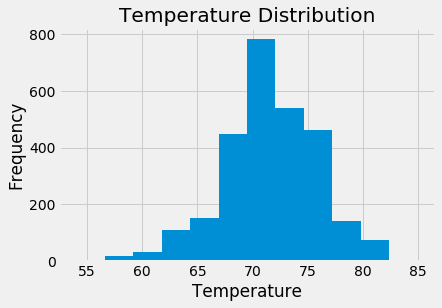

In [463]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results5 = session.query(Measurement.station, Measurement.tobs)
station_data5 = [result[0] for result in results5[:]]
tobs_data5 = [result[1] for result in results5[:]]
most_tobs_stations = pd.DataFrame(list(zip(station_data5, tobs_data5)),columns=["Station","TOBS"])
most_tobs_stations = most_tobs_stations.groupby(["Station"]).count()
most_tobs_stations = most_tobs_stations.sort_values(by=["TOBS"],ascending=False)
print(most_tobs_stations)
#station with most temp observations is USC00519281

results6 = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281")
temps_to_plot = [result[0] for result in results6[:]]

plt.hist(x=temps_to_plot,bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Temperature Distribution")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
